<font face="Arial" size="8" color="black">
    Dynamic Pricing Model (Stochasticity) <br><br>May 24, 2019
</font>

# Define some functions

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [300]:
def get_exp_dist(mbt = 7, size = 10_000):
    """
    returns array of booking times
    """
    
    np.random.seed(1)
    bookings = np.random.exponential(mbt+1, size)
    
    return bookings


def get_hist(s):
    """
    returns days, probs
    """
    s = s.round()
    probs, vals = np.histogram(s, bins=int(s.max()), density=False)
    probs = np.divide(probs, np.sum(probs))
    vals = vals[:-1]
    
    return vals,probs


def get_normal_dist(mrp = 65, std = 25, size = 10_000):
    """
    returns an array of normally distributed prices
    
    mrp = mean reserve price
        the max a customer is willing to pay.
        
    std = standard deviation of skew
        95% of the data fits within 2 std's        
        
    """
    np.random.seed(1)
    audience = np.random.normal(mrp, std, size)
    return audience

def get_lognormal_dist(mrp = 65, std = 25, size = 10_000):
    """
    returns an array of reservation prices
    
    mrp = mean reserve price
        the max a customer is willing to pay.
        
    std = standard deviation of skew
        95% of the data fits within 2 std's        
        
    """
    # first get normal distributions
    np.random.seed(1)
    audience = np.random.normal(mrp, std, size)

    # calculate the log values for mu and sigma
    mu = np.log(audience.mean())
    sigma = (mu - np.log(audience.std()))/2
    
    mu = mu - 0.5*(sigma**2)
    
    log_audience = np.random.lognormal(mu, sigma, size)

    return log_audience

# Generate audience behaviors

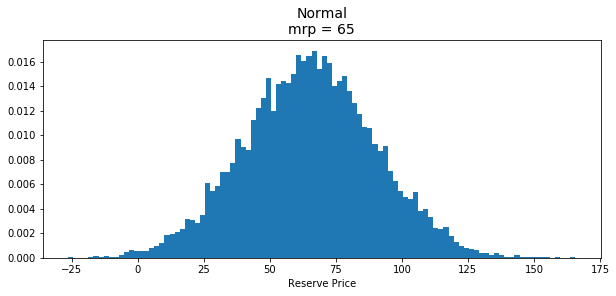

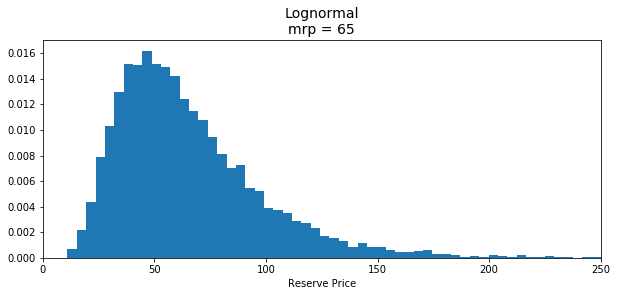

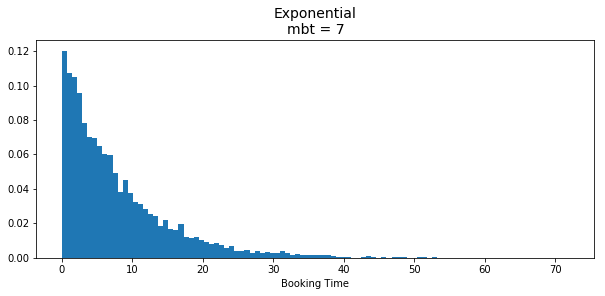

In [301]:
audience = get_normal_dist(mrp=65, std=25)
plt.figure(figsize=(10,4))
plt.title(f'Normal\nmrp = {int(audience.mean())}', size =14)
plt.hist(audience, bins=100, density=True)
plt.xlabel('Reserve Price')
plt.show()

# ---------------------------

audience = get_lognormal_dist(mrp=65, std=25)
plt.figure(figsize=(10,4))
plt.title(f'Lognormal\nmrp = {int(audience.mean())}', size =14)
plt.hist(audience, bins=100, density=True)
plt.xlabel('Reserve Price')
plt.xlim(left=0, right=250)
plt.show()

# ---------------------------
bookings = get_exp_dist(mbt=7)
plt.figure(figsize=(10,4))
plt.title(f'Exponential\nmbt = {int(bookings.mean())}', size =14)
plt.hist(bookings, bins=100, density=True)
plt.xlabel('Booking Time')

plt.show()

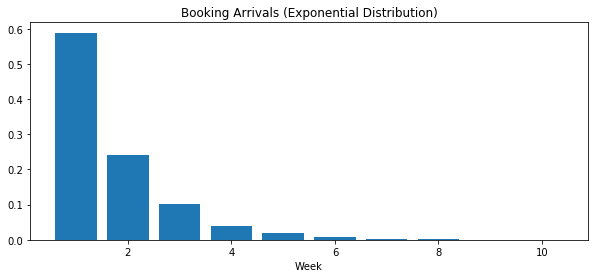

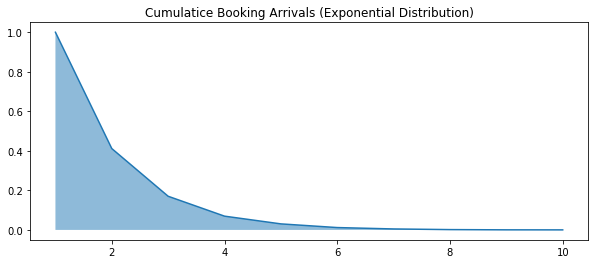

In [306]:
bookings = get_exp_dist(mbt=7)
bookings_w = ((bookings//7))+1

probs, weeks = np.histogram(bookings_w, bins=len(np.unique(bookings_w))-1, density=False)
probs = probs/size

plt.figure(figsize=(10,4))
plt.title('Booking Arrivals (Exponential Distribution)')
plt.bar(weeks[:-1], probs)
plt.xlabel('Week')
plt.show()

plt.figure(figsize=(10,4))
plt.title('Cumulatice Booking Arrivals (Exponential Distribution)')
cum_sum_probs = np.cumsum(probs[::-1])[::-1]
plt.plot(weeks[:-1], cum_sum_probs)
plt.fill_between(weeks[:-1], 0, cum_sum_probs, alpha=0.5)
plt.show()

# Simulate Purchasing Behavior

## First with weeks

In [777]:
mbt=7
bookings = get_exp_dist(mbt=mbt)
bookings_w = ((bookings//7))

In [778]:
probs, weeks = np.histogram(bookings_w, bins=len(np.unique(bookings_w))-1, density=False)
probs = np.divide(probs, probs.sum())
weeks_prob = dict([(w,p) for w,p in zip(weeks, probs)])
cum_probs = np.cumsum(probs[::-1])[::-1]
weeks_cum_prob = dict([(w,p) for w,p in zip(weeks, cum_probs)])
weeks_use = weeks[-2::-1]

In [779]:
n_cust = 0
stoch_curr = 0

weeks_dict = {x:{} for x in weeks_use}

for week in weeks_use:
    # A placeholder for when potential customers are affected by additional probabilities
    n_potential = 1 
    demand_reg = weeks_prob[week]*n_potential

    
    # how many customers?
    n_cust += demand_reg
    
    # create stochasticity
    stoch = (n_cust)**2
    
    weeks_dict[week]['demand'] = demand_reg
    weeks_dict[week]['stoch'] = stoch
    weeks_dict[week]['demand_stoch'] = demand_reg*(1+stoch)    

In [780]:
import pandas as pd
df = pd.DataFrame(weeks_dict).T
df.index.name = 'Week'
# df.sort_index(inplace=True)
df

,demand,demand_stoch,stoch
Week,,,
9.0,0.0002,0.000200,4.000000e-08
8.0,0.0002,0.000200,1.600000e-07
7.0,0.0012,0.001200,2.560000e-06
6.0,0.0033,0.003300,2.401000e-05
5.0,0.0070,0.007001,1.416100e-04
4.0,0.0186,0.018617,9.302500e-04
3.0,0.0391,0.039289,4.844160e-03
2.0,0.1006,0.103514,2.896804e-02
1.0,0.2413,0.282160,1.693322e-01


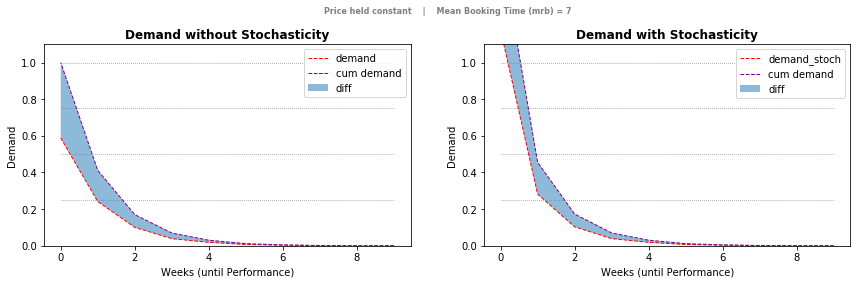

In [782]:
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(1,2,1)

# ------------------------

ax1.plot(df.demand, c='r', linestyle ='--', linewidth = 1)
ax1.plot(df.demand.cumsum(), c='purple', linestyle ='--',linewidth = 1, label = 'cum demand')
ax1.fill_between(df.index, df.demand.cumsum(),df.demand,alpha = 0.5, label='diff')

ax1.set_ylim(0,1.1)
ax1.hlines([0.25,0.50,0.75,1],df.index.min(),df.index.max(), linewidth=0.75, linestyle=':', color='grey')

ax1.set_title('Demand without Stochasticity', size = 12, weight = 'heavy')
ax1.legend()
ax1.set_xlabel('Weeks (until Performance)')
ax1.set_ylabel('Demand')

# ------------------------

ax2 = fig.add_subplot(1,2,2)
ax2.plot(df.demand_stoch, c='r', linestyle ='--', linewidth = 1)
ax2.plot(df.demand_stoch.cumsum(), c='purple', linestyle ='--',linewidth = 1, label = 'cum demand')
ax2.fill_between(df.index, df.demand_stoch.cumsum(),df.demand_stoch,alpha = 0.5, label='diff')
ax2.set_ylim(0,1.1)
ax2.hlines([0.25,0.50,0.75,1],df.index.min(),df.index.max(), linewidth=0.75, linestyle=':', color='grey')

ax2.set_title('Demand with Stochasticity', size = 12, weight = 'heavy')
ax2.legend()
ax2.set_xlabel('Weeks (until Performance)')
ax2.set_ylabel('Demand')

# ------------------------

title_save ='weeks – demand for bookings w stoch'
plt.suptitle(f'Price held constant    |    Mean Booking Time (mrb) = {mbt}', size = 8, color= 'grey', weight='heavy')
plt.subplots_adjust(top=0.85, bottom = 0.15, wspace=0.20, left=0.10, right=0.90)

# plt.savefig(f'title_save Mbt ({mbt}).png', dpi = 150)

plt.show()


## Now for days

In [783]:
bookings = get_exp_dist(mbt=7)

In [784]:
probs, days = np.histogram(bookings, bins=range(0,int(bookings.max())), density=False)
probs = np.divide(probs, probs.sum())
days_prob = dict([(w,p) for w,p in zip(days, probs)])
cum_probs = np.cumsum(probs[::-1])[::-1]
days_cum_prob = dict([(w,p) for w,p in zip(days, cum_probs)])
days_use = days[-2::-1]

In [785]:
n_cust = 0
stoch_curr = 0

days_dict = {x:{} for x in days_use}

for day in days_use:
    # A placeholder for when potential customers are affected by additional probabilities
    n_potential = 1 
    demand_reg = days_prob[day]*n_potential

    
    # how many customers?
    n_cust += demand_reg
    
    # create stochasticity
    stoch = (n_cust)**2
    
    days_dict[day]['demand'] = demand_reg
    days_dict[day]['stoch'] = stoch
    days_dict[day]['demand_stoch'] = demand_reg*(1+stoch)    

In [786]:
import pandas as pd
df = pd.DataFrame(days_dict).T
df.index.name = 'Day'
# # df.sort_index(inplace=True)
df['demand_cumsum'] = df.demand.cumsum()
df['demand_stoch_cumsum'] = df.demand_stoch.cumsum()
df.head()

,demand,demand_stoch,stoch,demand_cumsum,demand_stoch_cumsum
Day,,,,,
69,0.0000,0.0000,0.000000e+00,0.0000,0.0000
68,0.0000,0.0000,0.000000e+00,0.0000,0.0000
67,0.0000,0.0000,0.000000e+00,0.0000,0.0000
66,0.0001,0.0001,1.000200e-08,0.0001,0.0001
65,0.0000,0.0000,1.000200e-08,0.0001,0.0001


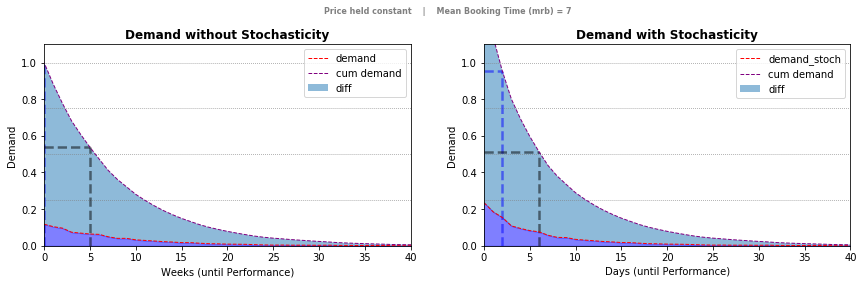

In [787]:
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(1,2,1)

# ------------------------

ax1.plot(df.demand, c='r', linestyle ='--', linewidth = 1)
ax1.plot(df.demand_cumsum, c='purple', linestyle ='--',linewidth = 1, label = 'cum demand')
ax1.fill_between(df.index, df.demand_cumsum,df.demand,alpha = 0.5, label='diff')
ax1.fill_between(df.index, 0, df.demand, color ='b', alpha = 0.5)

ax1.set_ylim(0,1.1)
ax1.hlines([0.25,0.50,0.75,1],df.index.min(),df.index.max(), linewidth=0.75, linestyle=':', color='grey')

# plot lines when demand peaks 0.50 and 0.95
d_50 = df[df.demand_cumsum>=0.5].index.max()
d_90 = df[df.demand_cumsum>=0.90].index.max()
d_50_y = df.demand_cumsum[d_50]
d_90_y = df.demand_cumsum[d_90]
ax1.vlines([d_50, d_90],0,[d_50_y,d_90_y], color= ['k','b'], linestyle='--', linewidth = 2.50, alpha=0.5)
ax1.hlines([d_50_y,d_90_y],df.index.min(), [d_50, d_90], color= ['k','b'], linestyle='--', linewidth = 2.50, alpha=0.5)



ax1.set_title('Demand without Stochasticity', size = 12, weight = 'heavy')
ax1.legend()
ax1.set_xlabel('Weeks (until Performance)')
ax1.set_ylabel('Demand')

ax1.set_xlim(left=0, right=40)
# ------------------------

ax2 = fig.add_subplot(1,2,2)
ax2.plot(df.demand_stoch, c='r', linestyle ='--', linewidth = 1)
ax2.plot(df.demand_stoch_cumsum, c='purple', linestyle ='--',linewidth = 1, label = 'cum demand')
ax2.fill_between(df.index, df.demand_stoch_cumsum,df.demand_stoch,alpha = 0.5, label='diff')
ax2.fill_between(df.index, 0, df.demand_stoch, color ='b', alpha = 0.5)

ax2.set_ylim(0,1.1)
ax2.hlines([0.25,0.50,0.75,1],df.index.min(),df.index.max(), linewidth=0.75, linestyle=':', color='grey')

# plot lines when demand peaks 0.50 and 0.95
d_50 = df[df.demand_stoch_cumsum>=0.5].index.max()
d_90 = df[df.demand_stoch_cumsum>=0.90].index.max()
d_50_y = df.demand_stoch_cumsum[d_50]
d_90_y = df.demand_stoch_cumsum[d_90]
ax2.vlines([d_50, d_90],0,[d_50_y,d_90_y], color= ['k','b'], linestyle='--', linewidth = 2.50, alpha=0.5)
ax2.hlines([d_50_y,d_90_y],df.index.min(), [d_50, d_90], color= ['k','b'], linestyle='--', linewidth = 2.50, alpha=0.5)


ax2.set_title('Demand with Stochasticity', size = 12, weight = 'heavy')
ax2.legend()
ax2.set_xlabel('Days (until Performance)')
ax2.set_ylabel('Demand')

ax2.set_xlim(left=0, right=40)
# ------------------------

title_save ='days – demand for bookings w stoch'
plt.suptitle(f'Price held constant    |    Mean Booking Time (mrb) = {mbt}', size = 8, color= 'grey', weight='heavy')
plt.subplots_adjust(top=0.85, bottom = 0.15, wspace=0.20, left=0.10, right=0.90)

# plt.savefig(f'title_save Mbt ({mbt}).png', dpi = 150)

plt.show()


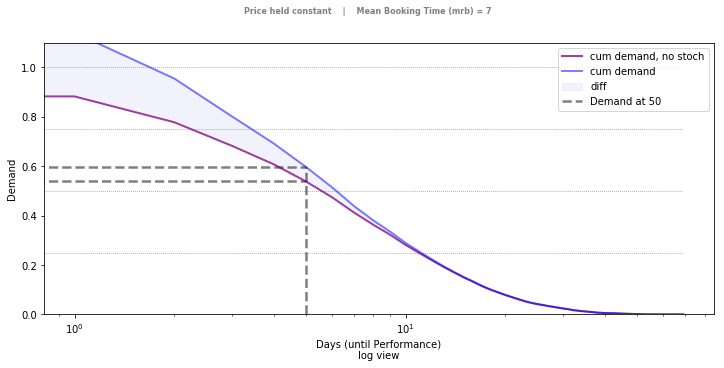

In [788]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,1,1)

# ------------------------

ax1.plot(df.demand_cumsum, c='purple', linestyle ='-',linewidth = 2.0, label = 'cum demand, no stoch', alpha = 0.750)
ax1.plot(df.demand_stoch_cumsum, c='blue', linestyle ='-',linewidth = 2.0, label = 'cum demand', alpha = 0.50)
ax1.fill_between(df.index, df.demand_stoch_cumsum,df.demand_cumsum, color ='Lavender', alpha = 0.5, label='diff')


# Set the limits + horizontal lines
ax1.set_ylim(0,1.1)
ax1.hlines([0.25,0.50,0.75,1],df.index.min(),df.index.max(), linewidth=0.75, linestyle=':', color='grey')



d_50 = df[df.demand_cumsum>=0.50].index.max()
d_50_y_1 = df.demand_cumsum[d_50]
d_50_y_2 = df.demand_stoch_cumsum[d_50]


ax1.vlines([d_50],0,[d_50_y_2], linestyle='--', linewidth = 2.50, alpha=0.50, label='Demand at 50')
ax1.hlines([d_50_y_1,d_50_y_2],df.index.min(), [d_50, d_50], linestyle='--', linewidth = 2.50, alpha=0.50)



ax1.legend()
ax1.set_xlabel('Days (until Performance)\nlog view')
ax1.set_ylabel('Demand')

ax1.set_xscale('log')

title_save ='days – demand for bookings – compared (log)'
plt.suptitle(f'Price held constant    |    Mean Booking Time (mrb) = {mbt}', size = 8, color= 'grey', weight='heavy')
# plt.subplots_adjust(top=0.85, bottom = 0.15, wspace=0.20, left=0.10, right=0.90)

# plt.savefig(f'title_save Mbt ({mbt}).png', dpi = 150)


plt.show()

## Generate Demand

In [789]:
df.head()

,demand,demand_stoch,stoch,demand_cumsum,demand_stoch_cumsum
Day,,,,,
69,0.0000,0.0000,0.000000e+00,0.0000,0.0000
68,0.0000,0.0000,0.000000e+00,0.0000,0.0000
67,0.0000,0.0000,0.000000e+00,0.0000,0.0000
66,0.0001,0.0001,1.000200e-08,0.0001,0.0001
65,0.0000,0.0000,1.000200e-08,0.0001,0.0001


# What if you give away free tickets?

In [790]:
bookings = get_exp_distribution(mbt=7)

In [791]:
probs, days = np.histogram(bookings, bins=range(0,int(bookings.max())), density=False)
probs = np.divide(probs, probs.sum())
days_prob = dict([(w,p) for w,p in zip(days, probs)])
cum_probs = np.cumsum(probs[::-1])[::-1]
days_cum_prob = dict([(w,p) for w,p in zip(days, cum_probs)])
days_use = days[-2::-1]

In [792]:
n_cust = 0.1

days_dict = {x:{} for x in days_use}

for day in days_use:
    # A placeholder for when potential customers are affected by additional probabilities
    n_potential = 1 
    demand_reg = days_prob[day]*n_potential

    
    # how many customers?
    n_cust += demand_reg
    
    # create stochasticity
    stoch = (n_cust)**2
    
    days_dict[day]['demand'] = demand_reg
    days_dict[day]['stoch'] = stoch
    days_dict[day]['demand_stoch'] = demand_reg*(1+stoch)    

In [793]:
import pandas as pd
df = pd.DataFrame(days_dict).T
df.index.name = 'Day'
# # df.sort_index(inplace=True)
df['demand_cumsum'] = df.demand.cumsum()
df['demand_stoch_cumsum'] = df.demand_stoch.cumsum()
df.head()

,demand,demand_stoch,stoch,demand_cumsum,demand_stoch_cumsum
Day,,,,,
60,0.0000,0.000000,0.01000,0.0000,0.000000
59,0.0000,0.000000,0.01000,0.0000,0.000000
58,0.0001,0.000101,0.01002,0.0001,0.000101
57,0.0000,0.000000,0.01002,0.0001,0.000101
56,0.0000,0.000000,0.01002,0.0001,0.000101


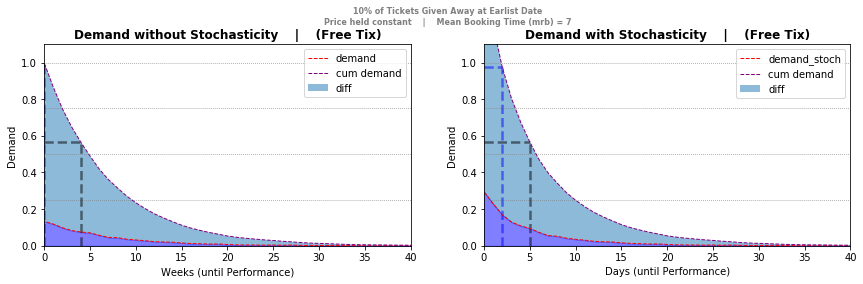

In [797]:
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(1,2,1)

# ------------------------

ax1.plot(df.demand, c='r', linestyle ='--', linewidth = 1)
ax1.plot(df.demand_cumsum, c='purple', linestyle ='--',linewidth = 1, label = 'cum demand')
ax1.fill_between(df.index, df.demand_cumsum,df.demand,alpha = 0.5, label='diff')
ax1.fill_between(df.index, 0, df.demand, color ='b', alpha = 0.5)

ax1.set_ylim(0,1.1)
ax1.hlines([0.25,0.50,0.75,1],df.index.min(),df.index.max(), linewidth=0.75, linestyle=':', color='grey')

# plot lines when demand peaks 0.50 and 0.95
d_50 = df[df.demand_cumsum>=0.5].index.max()
d_90 = df[df.demand_cumsum>=0.90].index.max()
d_50_y = df.demand_cumsum[d_50]
d_90_y = df.demand_cumsum[d_90]
ax1.vlines([d_50, d_90],0,[d_50_y,d_90_y], color= ['k','b'], linestyle='--', linewidth = 2.50, alpha=0.5)
ax1.hlines([d_50_y,d_90_y],df.index.min(), [d_50, d_90], color= ['k','b'], linestyle='--', linewidth = 2.50, alpha=0.5)



ax1.set_title('Demand without Stochasticity    |    (Free Tix)', size = 12, weight = 'heavy')
ax1.legend()
ax1.set_xlabel('Weeks (until Performance)')
ax1.set_ylabel('Demand')

ax1.set_xlim(left=0, right=40)
# ------------------------

ax2 = fig.add_subplot(1,2,2)
ax2.plot(df.demand_stoch, c='r', linestyle ='--', linewidth = 1)
ax2.plot(df.demand_stoch_cumsum, c='purple', linestyle ='--',linewidth = 1, label = 'cum demand')
ax2.fill_between(df.index, df.demand_stoch_cumsum,df.demand_stoch,alpha = 0.5, label='diff')
ax2.fill_between(df.index, 0, df.demand_stoch, color ='b', alpha = 0.5)

ax2.set_ylim(0,1.1)
ax2.hlines([0.25,0.50,0.75,1],df.index.min(),df.index.max(), linewidth=0.75, linestyle=':', color='grey')

# plot lines when demand peaks 0.50 and 0.95
d_50 = df[df.demand_stoch_cumsum>=0.5].index.max()
d_90 = df[df.demand_stoch_cumsum>=0.90].index.max()
d_50_y = df.demand_stoch_cumsum[d_50]
d_90_y = df.demand_stoch_cumsum[d_90]
ax2.vlines([d_50, d_90],0,[d_50_y,d_90_y], color= ['k','b'], linestyle='--', linewidth = 2.50, alpha=0.5)
ax2.hlines([d_50_y,d_90_y],df.index.min(), [d_50, d_90], color= ['k','b'], linestyle='--', linewidth = 2.50, alpha=0.5)


ax2.set_title('Demand with Stochasticity    |    (Free Tix)', size = 12, weight = 'heavy')
ax2.legend()
ax2.set_xlabel('Days (until Performance)')
ax2.set_ylabel('Demand')

ax2.set_xlim(left=0, right=40)
# ------------------------

title_save ='days – demand for bookings w stoch – 10 percent free tix'
plt.suptitle(f'10% of Tickets Given Away at Earlist Date\nPrice held constant    |    Mean Booking Time (mrb) = {mbt}', size = 8, color= 'grey', weight='heavy')
plt.subplots_adjust(top=0.85, bottom = 0.15, wspace=0.20, left=0.10, right=0.90)

# plt.savefig(f'title_save Mbt ({mbt}).png', dpi = 150)

plt.show()


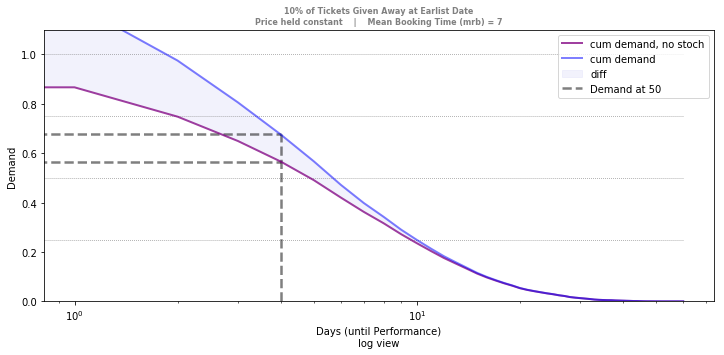

In [799]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,1,1)

# ------------------------

ax1.plot(df.demand_cumsum, c='purple', linestyle ='-',linewidth = 2.0, label = 'cum demand, no stoch', alpha = 0.750)
ax1.plot(df.demand_stoch_cumsum, c='blue', linestyle ='-',linewidth = 2.0, label = 'cum demand', alpha = 0.50)
ax1.fill_between(df.index, df.demand_stoch_cumsum,df.demand_cumsum, color ='Lavender', alpha = 0.5, label='diff')


# Set the limits + horizontal lines
ax1.set_ylim(0,1.1)
ax1.hlines([0.25,0.50,0.75,1],df.index.min(),df.index.max(), linewidth=0.75, linestyle=':', color='grey')



d_50 = df[df.demand_cumsum>=0.50].index.max()
d_50_y_1 = df.demand_cumsum[d_50]
d_50_y_2 = df.demand_stoch_cumsum[d_50]


ax1.vlines([d_50],0,[d_50_y_2], linestyle='--', linewidth = 2.50, alpha=0.50, label='Demand at 50')
ax1.hlines([d_50_y_1,d_50_y_2],df.index.min(), [d_50, d_50], linestyle='--', linewidth = 2.50, alpha=0.50)



ax1.legend()
ax1.set_xlabel('Days (until Performance)\nlog view')
ax1.set_ylabel('Demand')

ax1.set_xscale('log')

title_save ='days – demand for bookings – compared (log) – 10 percent free tix'
plt.title(f'10% of Tickets Given Away at Earlist Date\nPrice held constant    |    Mean Booking Time (mrb) = {mbt}', size = 8, color= 'grey', weight='heavy')
# plt.subplots_adjust(top=0.85, bottom = 0.15, wspace=0.20, left=0.10, right=0.90)

plt.savefig(f'title_save Mbt ({mbt}).png', dpi = 150)


plt.show()

In [800]:
def plot_demands(df_use=df, col_1='demand',col_2='demand_stoch'):
    fig = plt.figure(figsize=(10,4))

    # ------------------------

    ax1 = fig.add_subplot(1,1,1)

    # ------------------------

    ax1.plot(df_use[col_1], c='orange', linestyle ='--', linewidth = 1)
    ax1.plot(df_use[col_2], c='red', linestyle ='--', linewidth = 1)
    ax1.fill_between(df_use.index, df_use[col_1], df_use[col_2] ,
                     where=df_use.index>0,alpha = 0.5, label='diff')

    # -  -  -  -  -  -  -  -
    ax1.legend()

    # -  -  -  -  -  -  -  -
    ax1.set_title(f'{col_1.title()} and {col_2.title()}' ,size = 14, color= 'grey', weight = 'heavy')
    ax1.set_xlabel('Days (until Performance)')
    ax1.set_ylabel('Demand')


    # ------------------------
    title_save ='demand for bookings w stoch (neater)'
    os.makedirs(os.path.join('..output', f'Mbt {mbt}'),exist_ok=True)
    image_path = os.path.join('..output', f'Mbt {mbt}', title_save +'.png')

    # ------------------------
    # plt.savefig(image_path, dpi = 150)
    plt.show()


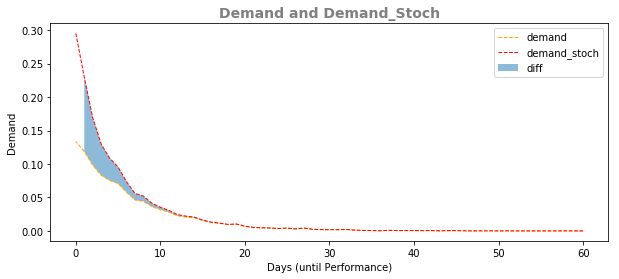

In [801]:
plot_demands()

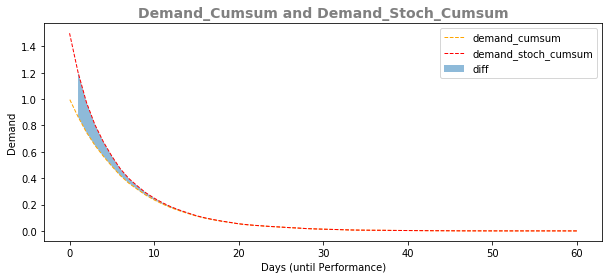

In [802]:
plot_demands(col_1='demand_cumsum', col_2 = 'demand_stoch_cumsum')

# Compare Simulations

## Get Demands

In [804]:
bookings = get_exp_distribution(mbt=7)

In [805]:
probs, days = np.histogram(bookings, bins=range(0,int(bookings.max())), density=False)
probs = np.divide(probs, probs.sum())
days_prob = dict([(w,p) for w,p in zip(days, probs)])
cum_probs = np.cumsum(probs[::-1])[::-1]
days_cum_prob = dict([(w,p) for w,p in zip(days, cum_probs)])
days_use = days[-2::-1]

In [ ]:
for x in [0,0.05,0.1,0.2,0.3, 0.5]:

days_dict = {x:{} for x in days_use}

for day in days_use:
    # A placeholder for when potential customers are affected by additional probabilities
    n_potential = 1 
    demand_reg = days_prob[day]*n_potential

    
    # how many customers?
    n_cust += demand_reg
    
    # create stochasticity
    stoch = (n_cust)**2
    
    days_dict[day]['demand'] = demand_reg
    days_dict[day]['stoch'] = stoch
    days_dict[day]['demand_stoch'] = demand_reg*(1+stoch)    

In [806]:
cum_demands = []
cols_x =[]

for x in [0,0.05,0.1,0.2,0.3, 0.5]:
    values = []

    n_cust_curr = n_begin = x

    stoch = 0

    for day in days_use:
        n_potential = 1
        demand_rel = days_prob[day]*n_potential

        # how many customers?
        n_cust_curr += demand_rel

        # create stochasticity
        stoch = (n_cust_curr)**2

        values.append({
            'Day':day,
            'Stochasticity': stoch,
            'Demand': demand_rel,
            'Demand_Stoch': demand_rel*(1+stoch)
            })

    values_df = pd.DataFrame(values[::-1])
    values_df.set_index('Day', inplace=True)
    values_df.sort_index(inplace=True)
    values_df['Cum_Demand'] = values_df['Demand'][::-1].cumsum()
    values_df['Cum_Demand_Stoch'] = values_df['Demand_Stoch'][::-1].cumsum()
    
    cols_x.append(f'Cum_Demand_Stoch_at_{x}')
    cum_demands.append(values_df.Cum_Demand_Stoch)
    
cum_demands.append(values_df.Cum_Demand)
cols_x.append('Cum_Demand (No Stoch)')

In [807]:
df_simulation = pd.concat(cum_demands,axis=1)
df_simulation.columns = cols_x
df_simulation = df_simulation = df_simulation.reindex(sorted(df_simulation.columns), axis=1)
df_simulation.index = df_simulation.index+1
df_simulation.head(5)

,Cum_Demand (No Stoch),Cum_Demand_Stoch_at_0,Cum_Demand_Stoch_at_0.05,Cum_Demand_Stoch_at_0.1,Cum_Demand_Stoch_at_0.2,Cum_Demand_Stoch_at_0.3,Cum_Demand_Stoch_at_0.5
Day,,,,,,,
1,1.000000,1.382331,1.438432,1.499533,1.636735,1.793937,2.168341
2,0.866387,1.115104,1.157510,1.204247,1.310718,1.434517,1.734098
3,0.747675,0.907284,0.939108,0.974670,1.057010,1.154303,1.393750
4,0.649265,0.753861,0.778081,0.805548,0.870219,0.947876,1.142146
5,0.566157,0.635719,0.654335,0.675782,0.727169,0.789879,0.949267


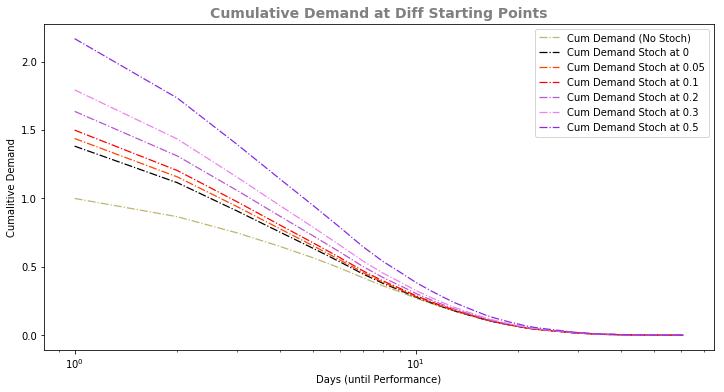

In [813]:
def plot_demands_simulate(df_use=df_simulation):
    fig = plt.figure(figsize=(12,6))

    colors = ['darkkhaki','black','orangered','red','MediumOrchid','violet','blueviolet']
    # ------------------------

    ax1 = fig.add_subplot(1,1,1)

    # ------------------------
    i=0
    for col in df_use:
        ax1.plot(df_use[col], linestyle ='-.', linewidth = 1.25, color = colors[i], label = ' '.join(col.split('_')))
        i+=1
    ax1.legend()
    
    # -  -  -  -  -  -  -  -
    ax1.set_title(f'Cumulative Demand at Diff Starting Points',size = 14, color= 'grey', weight = 'heavy')
    ax1.set_xlabel('Days (until Performance)')
    ax1.set_ylabel('Cumalitive Demand')

    ax1.set_xscale('log')

    # ------------------------
    title_save ='cum demand when give free seats'
    os.makedirs(os.path.join('..output', f'Mbt {mbt}'),exist_ok=True)
    image_path = os.path.join('..output', f'Mbt {mbt}', title_save +'.png')


    plt.savefig(image_path, dpi = 150)
    plt.show()

    
plot_demands_simulate(df_simulation)

## Adjust for Price

In [833]:
df_simulation.head(5)

,Cum_Demand (No Stoch),Cum_Demand_Stoch_at_0,Cum_Demand_Stoch_at_0.05,Cum_Demand_Stoch_at_0.1,Cum_Demand_Stoch_at_0.2,Cum_Demand_Stoch_at_0.3,Cum_Demand_Stoch_at_0.5
Day,,,,,,,
1,1.000000,1.382331,1.438432,1.499533,1.636735,1.793937,2.168341
2,0.866387,1.115104,1.157510,1.204247,1.310718,1.434517,1.734098
3,0.747675,0.907284,0.939108,0.974670,1.057010,1.154303,1.393750
4,0.649265,0.753861,0.778081,0.805548,0.870219,0.947876,1.142146
5,0.566157,0.635719,0.654335,0.675782,0.727169,0.789879,0.949267


1.3823307513608678

In [893]:
Cum_Demand_Stoch_at_0 = round(df_simulation.Cum_Demand_Stoch_at_0[1],3)
print(f'Give away 0:\t\tDemand is = {Cum_Demand_Stoch_at_0}\n')  
    
for col in df_simulation.columns:
    if '0.' in col:
        give_away = float(col.split('_')[-1])
        dem = round(df_simulation[col][1],3)
        print(f'Give away {give_away}\t\tDemand is = {dem}')
        print(f'Adjust demand \t\t{dem} - {give_away} = {round(dem-give_away,3)}')
        print(f'Diff in demand: \t{dem-give_away} - {Cum_Demand_Stoch_at_0} = {round(dem-give_away-Cum_Demand_Stoch_at_0,3)}')
        print(f'* Gain: {round(dem-give_away-Cum_Demand_Stoch_at_0,3)}\n')
        

Give away 0:		Demand is = 1.382

Give away 0.05		Demand is = 1.438
Adjust demand 		1.438 - 0.05 = 1.388
Diff in demand: 	1.388 - 1.382 = 0.006
* Gain: 0.006

Give away 0.1		Demand is = 1.5
Adjust demand 		1.5 - 0.1 = 1.4
Diff in demand: 	1.4 - 1.382 = 0.018
* Gain: 0.018

Give away 0.2		Demand is = 1.637
Adjust demand 		1.637 - 0.2 = 1.437
Diff in demand: 	1.437 - 1.382 = 0.055
* Gain: 0.055

Give away 0.3		Demand is = 1.794
Adjust demand 		1.794 - 0.3 = 1.494
Diff in demand: 	1.494 - 1.382 = 0.112
* Gain: 0.112

Give away 0.5		Demand is = 2.168
Adjust demand 		2.168 - 0.5 = 1.668
Diff in demand: 	1.6680000000000001 - 1.382 = 0.286
* Gain: 0.286

